In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os

from os import listdir


import uproot3


rc('text', usetex=True)

import matplotlib as mpl

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from matplotlib import gridspec
from matplotlib.font_manager import FontProperties

from numpy import inf

import os

rc('text', usetex=True)

import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

#
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

import matplotlib.pyplot as plt
import mplhep as hep
#hep.set_style(hep.style.CMS)
hep.set_style("CMS")


/home/miguel/.local/lib/python3.8/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/home/miguel/.local/lib/python3.8/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


In [2]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

plot_style_1A = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2A = {'alpha': 0.5, 'density': False}


In [3]:
def get_Dataframe(path, name='Data', tag=None):
    Files = listdir(path) 
    #print (Files)
    df = None
    for i, f in enumerate(Files):
        if( df is not None):
            if(df.shape[0]>5000000): continue
        #if(i>10):continue
        if name not in f: continue
        filename = path+f
        if not(tag is None) and (tag not in f): continue
        print ('filename is' , filename)
        
        temp_file = uproot3.open(filename)
        
        hasTree = False 
        
        print (temp_file.keys()) 
        
        if(len(temp_file.keys())<1):
            print('could not find %s, skipping'%name)
            continue
        
        if( not(name in str(temp_file.keys()[0]))):
            print('could not find %s, skipping'%name)
            continue
        
        for key in temp_file[name].keys():
            #print (key)
            if('minitree' in str(key)):
                hasTree=True
        if (not hasTree):
            print('file has not minitree, skipping')
            continue

        temp_tree = temp_file[name+'/minitree']

        
        temp_df = None
        
        if 'Data' not in name:
            try:
                temp_df   =  temp_tree.pandas.df(["Q2*","gen_Q2","y*","HFS*",'gen_y',"e_*","gene*",'wgt','vertex_z','ptmiss','ptratio*','Empz','pth','genHFS*'], entrystop=3e7,flatten=True)
                df = pd.concat([df,temp_df])
            except ValueError:
                print ('oops, there is a problem in flattening the TTree ')
        else:
            try:
                temp_df   =  temp_tree.pandas.df(["Q2*","y*","e_*","HFS*",'wgt','vertex_z','ptmiss','ptratio*','Empz','pth'], entrystop=3e7,flatten=True) 
                df = pd.concat([df,temp_df])
            except ValueError:
                print ('oops, there is a problem in flattening the TTree ')
        
        #try:
        #    df.shape[0]
        #except ValueError:
        #    print('no valid dataframe')
    print('####################################################################')
    if( not(df is None)):
        print('Dataframe has a total of ', df.shape[0], ' entries')
    else:
        print ('Dataframe has no entry, it is None')
    print('####################################################################')

    return df


In [4]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print (text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut))
    return cutDataframe

In [5]:
import math
def applyCutsJets(df,isMC=False):
    temp = df
    #temp = applyCut(temp, 'abs(vertex_z)<25 and vertex_z!=0','abs(vertex_z)<25 and and vertex_z!=0')
    temp.eval('e_pt = sqrt(e_px*e_px + e_py*e_py)',inplace=True)
    temp.eval('e_p = sqrt(e_px*e_px + e_py*e_py + e_pz*e_pz)',inplace=True)
    temp.eval('e_empz = e_p - e_pz', inplace=True)
    temp.eval('e_theta= arctan2(e_pt,e_pz) ',inplace=True)
    #temp.eval('e_eta  = -1.0*log(sin(0.5*e_theta)/cos(0.5*e_theta))',inplace=True)
    
    temp.eval('e_phi = arctan(e_py/e_px)', inplace=True)


    temp.eval('s = 4*27.6*920', inplace=True)
    temp.eval('x_e = Q2_e/(s*y_e)',inplace=True)
    temp.eval('x_da = Q2_da/(s*y_da)',inplace=True)
    temp.eval('x_sigma = Q2_sigma/(s*y_sigma)',inplace=True)
    temp.eval('x_esigma = x_sigma',inplace=True)
    temp.eval('x_h = Q2_h/(s*y_h)',inplace=True)

    temp.eval('Sigma = HFS_E - HFS_pz', inplace=True)
    temp.eval('my_EMPZ = Sigma + e_empz', inplace=True)
    temp.eval('HFS_pt = sqrt(HFS_px*HFS_px + HFS_py*HFS_py)',inplace=True)
    
    #temp.eval('HFS_eta = arcsinh(HFS_pz/HFS_pt)',inplace=True)
    temp.eval('gamma = 2.0*arctan(Sigma/HFS_pt)',inplace=True)
    temp.eval('HFS_theta = arctan2(HFS_pt,HFS_pz)',inplace=True)

    #temp.eval('HFS_theta = gamma', inplace=True)
    #temp.eval('HFS_eta = -1.0*log(sin(0.5*HFS_theta)/cos(0.5*HFS_theta))',inplace=True)
    
    
    #temp.eval('HFS_eta = -1.0*log(sin(0.5*gamma)/cos(0.5*gamma))',inplace=True)
    #temp.eval('HFS_eta = -1.0*log(sin(0.5*HFS_theta)/cos(0.5*HFS_theta))',inplace=True)


    #temp = applyCut(temp, 'pass_reco==0 | ptmiss < 10', 'ptmiss<10')

    #temp = applyCut(temp, 'pass_reco==0 | 0.08 < y_e < 0.7', '0.08 < y_e < 0.7')
    #temp = applyCut(temp, 'pass_reco==0 | Q2_e>150', 'Q2_e>150')
    #temp = applyCut(temp, 'pass_reco==0 | Empz<65', 'Empz<65')
    #temp = applyCut(temp, 'pass_reco==0 | Empz>45', 'Empz>45')
   
    if(isMC):
        #temp.eval('gen_x= gen_Q2/(s*gen_y)', inplace=True)   

        
        temp = applyCut(temp,'pass_truth>0',' pass_truth>0')
        temp = applyCut(temp,'gen_Q2>200',' gen_Q2>200')
        temp.eval('gen_x= gen_Q2/(s*gen_y)', inplace=True)   

        temp.eval('gen_logQ2= log(gen_Q2)/2.3025850', inplace=True)   
        temp.eval('gene_pt = sqrt(gene_px*gene_px + gene_py*gene_py)',inplace=True)
        temp.eval('gene_p = sqrt(gene_px*gene_px + gene_py*gene_py + gene_pz*gene_pz)',inplace=True)
        temp.eval('gene_theta= arctan2(gene_pt,gene_pz) ',inplace=True)
        temp.eval('genHFS_pt = sqrt(genHFS_px*genHFS_px + genHFS_py*genHFS_py)',inplace=True)

        temp.eval('yda_ratio = y_da/gen_y',inplace=True)
        temp.eval('ysigma_ratio = y_sigma/gen_y',inplace=True)
        temp.eval('yesigma_ratio = y_esigma/gen_y',inplace=True)
        temp.eval('ye_ratio = y_e/gen_y',inplace=True)
        temp.eval('yh_ratio = y_h/gen_y',inplace=True)

        temp.eval('Q2e_ratio = Q2_e/gen_Q2',inplace=True)
        temp.eval('Q2da_ratio = Q2_da/gen_Q2',inplace=True)
        temp.eval('Q2sigma_ratio = Q2_sigma/gen_Q2',inplace=True)
        temp.eval('Q2esigma_ratio = Q2_esigma/gen_Q2',inplace=True)
        temp.eval('Q2h_ratio = Q2_h/gen_Q2',inplace=True)

        temp.eval('xe_ratio = x_e/gen_x',inplace=True)
        temp.eval('xda_ratio = x_da/gen_x',inplace=True)
        temp.eval('xsigma_ratio = x_sigma/gen_x',inplace=True)
        temp.eval('xesigma_ratio = x_esigma/gen_x',inplace=True)
        temp.eval('xh_ratio = x_h/gen_x',inplace=True)
         
        temp.eval('p_res = e_p/gene_p -1.0',inplace=True)
        temp.eval('pt_res = e_pt/gene_pt -1.0',inplace=True)
        temp.eval('theta_res = e_theta/gene_theta-1.0',inplace=True)
        temp.eval('HFSpt_res = HFS_pt/genHFS_pt-1.0',inplace=True)


    #df = applyCut(df, 'n_total>1', ' n>1')
    return temp

In [6]:


temp_tree = uproot3.open('mini-tree_test6.root')['minitree']
print(temp_tree.keys())
owen2 =  temp_tree.pandas.df(["Q2*","gen_Q2","y*","HFS*",'gen_y',"e_*","gene*",'Empz','pth','gen_s','gen_HFS*'], entrystop=3e7,flatten=True)



temp_tree = uproot3.open('mini-tree_test7.root')['minitree']
#temp_tree = uproot3.open('mini-tree-trkres4-trk-and-ecal-good1.root')['minitree']
#temp_tree = uproot3.open('mini-tree-h1-hera-efeta2.4-bf.root')['minitree']
owen =  temp_tree.pandas.df(["Q2*","gen_Q2","y*","HFS*",'gen_y',"e_*","gene*",'Empz','pth','gen_s','gen_HFS*'], entrystop=3e7,flatten=True)



owen.eval('genHFS_px= gen_HFS_px',inplace=True)
owen.eval('genHFS_py= gen_HFS_py',inplace=True)
owen.eval('genHFS_pz= gen_HFS_pz',inplace=True)

owen2.eval('genHFS_px= gen_HFS_px',inplace=True)
owen2.eval('genHFS_py= gen_HFS_py',inplace=True)
owen2.eval('genHFS_pz= gen_HFS_pz',inplace=True)


[b'Q2_e', b'Q2_sigma', b'Q2_esigma', b'Q2_da', b'gen_Q2', b'y_e', b'y_sigma', b'y_esigma', b'y_da', b'HFS_px', b'HFS_py', b'HFS_pz', b'gen_y', b'e_px', b'e_py', b'e_pz', b'gene_px', b'gene_py', b'gene_pz', b'Empz', b'pth', b'x_sigma', b'x_e', b'x_da', b'y_h', b'Q2_h', b'x_h', b'gen_s', b'gen_x', b'HFS_E', b'gen_e_e', b'gen_e_pt', b'gen_e_eta', b'rec_e_eta', b'gen_e_phi', b'gen_e_theta', b'HFS_pt', b'HFS_eta', b'HFS_phi', b'HFS_theta', b'HFS_gamma', b'gen_HFS_px', b'gen_HFS_py', b'gen_HFS_pz', b'gen_HFS_e', b'gen_HFS_pt', b'gen_HFS_eta', b'gen_HFS_phi', b'gen_HFS_theta']


In [7]:
mc_name = 'Django'
altmc_name = 'Rapgap'
path ='/home/miguel/calostudies/21-07-16-00-44-july15/out_ep0607/'
mc_tag = 'nominal'

In [8]:
%%time 
mc = get_Dataframe(path, name=mc_name, tag=mc_tag)


filename is /home/miguel/calostudies/21-07-16-00-44-july15/out_ep0607/Django_Eplus0607_8.nominal.root
[b'Django;1']
filename is /home/miguel/calostudies/21-07-16-00-44-july15/out_ep0607/Django_Eplus0607_129.nominal.root
[b'Django;1']
filename is /home/miguel/calostudies/21-07-16-00-44-july15/out_ep0607/Django_Eplus0607_137.nominal.root
[b'Django;1']
filename is /home/miguel/calostudies/21-07-16-00-44-july15/out_ep0607/Django_Eplus0607_134.nominal.root
[b'Django;1']
filename is /home/miguel/calostudies/21-07-16-00-44-july15/out_ep0607/Django_Eplus0607_13.nominal.root
[b'Django;1']
filename is /home/miguel/calostudies/21-07-16-00-44-july15/out_ep0607/Django_Eplus0607_121.nominal.root
[b'Django;1']
####################################################################
Dataframe has a total of  5957479  entries
####################################################################
CPU times: user 3.95 s, sys: 440 ms, total: 4.39 s
Wall time: 4.39 s


In [9]:
%%time 

altmc = get_Dataframe(path, name=altmc_name, tag=mc_tag)

filename is /home/miguel/calostudies/21-07-16-00-44-july15/out_ep0607/Rapgap_Eplus0607_116.nominal.root
[b'Rapgap;1']
filename is /home/miguel/calostudies/21-07-16-00-44-july15/out_ep0607/Rapgap_Eplus0607_8.nominal.root
[b'Rapgap;1']
filename is /home/miguel/calostudies/21-07-16-00-44-july15/out_ep0607/Rapgap_Eplus0607_101.nominal.root
[b'Rapgap;1']
filename is /home/miguel/calostudies/21-07-16-00-44-july15/out_ep0607/Rapgap_Eplus0607_107.nominal.root
[b'Rapgap;1']
filename is /home/miguel/calostudies/21-07-16-00-44-july15/out_ep0607/Rapgap_Eplus0607_131.nominal.root
[b'Rapgap;1']
filename is /home/miguel/calostudies/21-07-16-00-44-july15/out_ep0607/Rapgap_Eplus0607_103.nominal.root
[b'Rapgap;1']
####################################################################
Dataframe has a total of  5949332  entries
####################################################################
CPU times: user 3.85 s, sys: 450 ms, total: 4.3 s
Wall time: 4.3 s


In [10]:
mc.keys()

Index(['Q2_e', 'Q2_sigma', 'Q2_esigma', 'Q2_da', 'Q2_h', 'gen_Q2', 'y_e',
       'y_sigma', 'y_esigma', 'y_da', 'y_h', 'HFS_px', 'HFS_py', 'HFS_pz',
       'HFS_E', 'HFS_eta', 'gen_y', 'e_px', 'e_py', 'e_pz', 'e_eta', 'gene_px',
       'gene_py', 'gene_pz', 'gene_eta', 'wgt', 'vertex_z', 'ptmiss',
       'ptratio_da', 'ptratio_ele', 'Empz', 'pth', 'genHFS_px', 'genHFS_py',
       'genHFS_pz', 'genHFS_E', 'genHFS_eta'],
      dtype='object')

In [11]:
owen2.keys()

Index(['Q2_e', 'Q2_sigma', 'Q2_esigma', 'Q2_da', 'Q2_h', 'gen_Q2', 'y_e',
       'y_sigma', 'y_esigma', 'y_da', 'y_h', 'HFS_px', 'HFS_py', 'HFS_pz',
       'HFS_E', 'HFS_pt', 'HFS_eta', 'HFS_phi', 'HFS_theta', 'HFS_gamma',
       'gen_y', 'e_px', 'e_py', 'e_pz', 'gene_px', 'gene_py', 'gene_pz',
       'Empz', 'pth', 'gen_s', 'gen_HFS_px', 'gen_HFS_py', 'gen_HFS_pz',
       'gen_HFS_e', 'gen_HFS_pt', 'gen_HFS_eta', 'gen_HFS_phi',
       'gen_HFS_theta', 'genHFS_px', 'genHFS_py', 'genHFS_pz'],
      dtype='object')

In [12]:
%%time 
mc['pass_reco'] = np.where(mc['Q2_e']>0, 1, 0)
mc['pass_truth'] = np.where(mc['gen_Q2']>0, 1, 0)

owen['pass_reco'] = np.where(owen['Q2_e']>0, 1, 0)
owen['pass_truth'] = np.where(owen['gen_Q2']>0, 1, 0)


owen2['pass_reco'] = np.where(owen2['Q2_e']>0, 1, 0)
owen2['pass_truth'] = np.where(owen2['gen_Q2']>0, 1, 0)

altmc['pass_reco'] = np.where(altmc['Q2_e']>0, 1, 0)
altmc['pass_truth'] = np.where(altmc['gen_Q2']>0, 1, 0)


CPU times: user 54.7 ms, sys: 15.5 ms, total: 70.2 ms
Wall time: 70 ms


In [13]:
%%time 
print('Selecting MC events\n')
mc   = applyCutsJets(mc, isMC=True)
print('Selecting MC events\n')
altmc   = applyCutsJets(altmc, isMC=True)

print('Selecting MC events\n')
owen   = applyCutsJets(owen, isMC=True)

print('Selecting MC events\n')
owen2   = applyCutsJets(owen2, isMC=True)

Selecting MC events

 pass_truth>0 5957479  fraction kept: 100.0
 gen_Q2>200 2170396  fraction kept: 36.4
Selecting MC events

 pass_truth>0 5949332  fraction kept: 100.0
 gen_Q2>200 2345046  fraction kept: 39.4
Selecting MC events

 pass_truth>0 79240  fraction kept: 100.0
 gen_Q2>200 79121  fraction kept: 99.8
Selecting MC events

 pass_truth>0 77805  fraction kept: 100.0
 gen_Q2>200 77687  fraction kept: 99.8
CPU times: user 3.64 s, sys: 1.59 s, total: 5.23 s
Wall time: 3.49 s


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


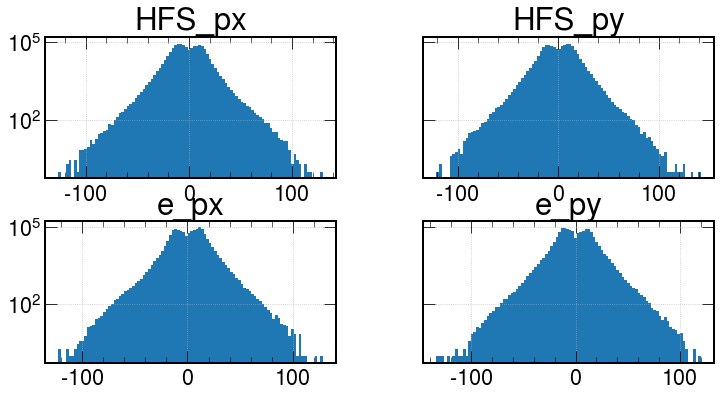

In [14]:
mc.query('pass_reco>0').hist(figsize=(12,6),bins=100,column=['HFS_px','HFS_py','e_px','e_py'],sharey=True)
plt.yscale('log')

plt.show()

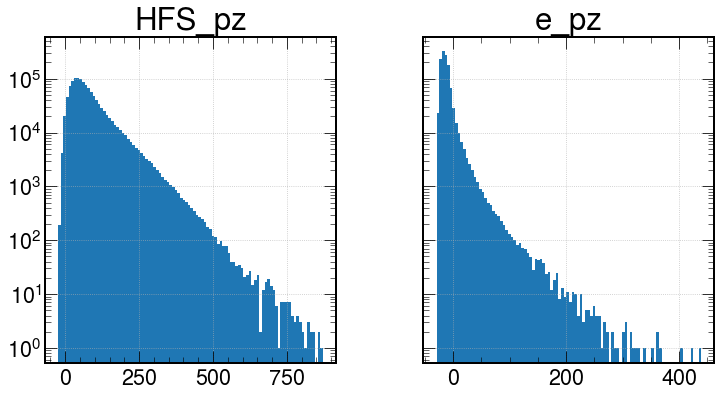

In [15]:
mc.query('pass_reco>0').hist(figsize=(12,6),bins=100,column=['HFS_pz','e_pz'],sharey=True)
plt.yscale('log')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0a421034c0>,
      dtype=object)

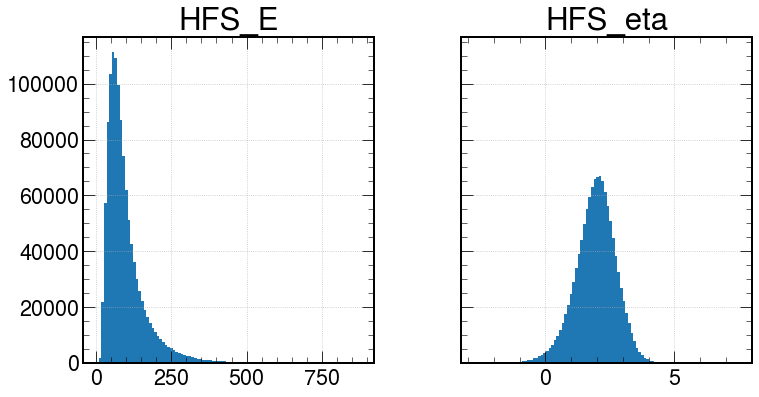

In [16]:
mc.query('pass_reco>0').hist(figsize=(12,6),bins=100,column=['HFS_E','HFS_eta'],sharey=True)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0a42a437f0>]],
      dtype=object)

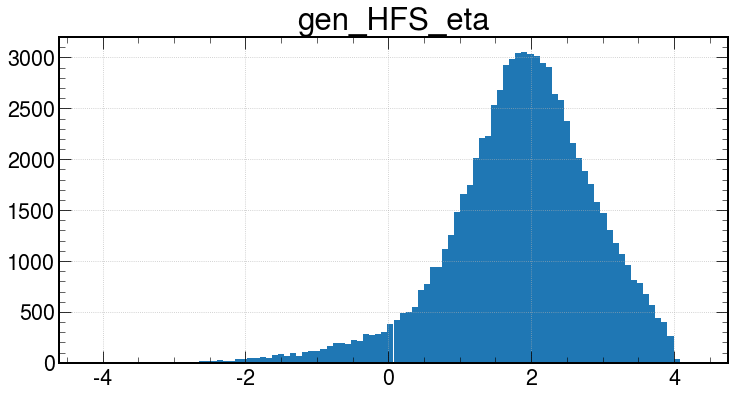

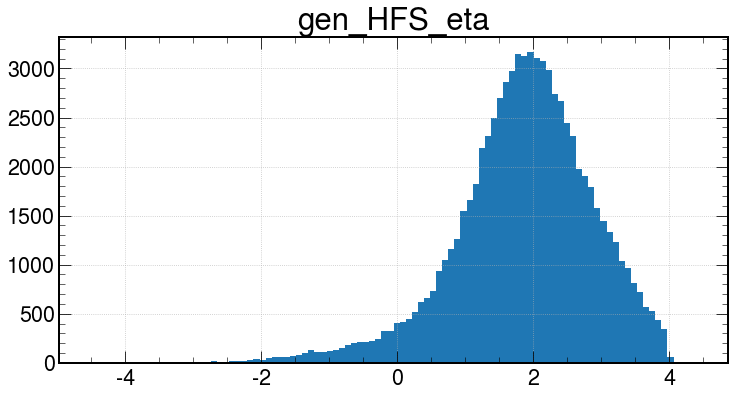

In [17]:
owen.query('pass_reco>0 and gen_HFS_eta<4.5').hist(figsize=(12,6),bins=100,column=['gen_HFS_eta'],sharey=True)
owen2.query('pass_reco>0 and gen_HFS_eta<4.5').hist(figsize=(12,6),bins=100,column=['gen_HFS_eta'],sharey=True)


['gen_y>0.5 and gen_y<0.75' 'gen_y>0.2 and gen_y<0.5'
 'gen_y>0.1 and gen_y<0.2' 'gen_y>0.05 and gen_y<0.1'
 'gen_y>0.01 and gen_y<0.05']
gen_y>0.5 and gen_y<0.75
gen_y>0.2 and gen_y<0.5
gen_y>0.1 and gen_y<0.2
gen_y>0.05 and gen_y<0.1
gen_y>0.01 and gen_y<0.05
gen_y>0.5 and gen_y<0.75
gen_y>0.2 and gen_y<0.5
gen_y>0.1 and gen_y<0.2
gen_y>0.05 and gen_y<0.1
gen_y>0.01 and gen_y<0.05


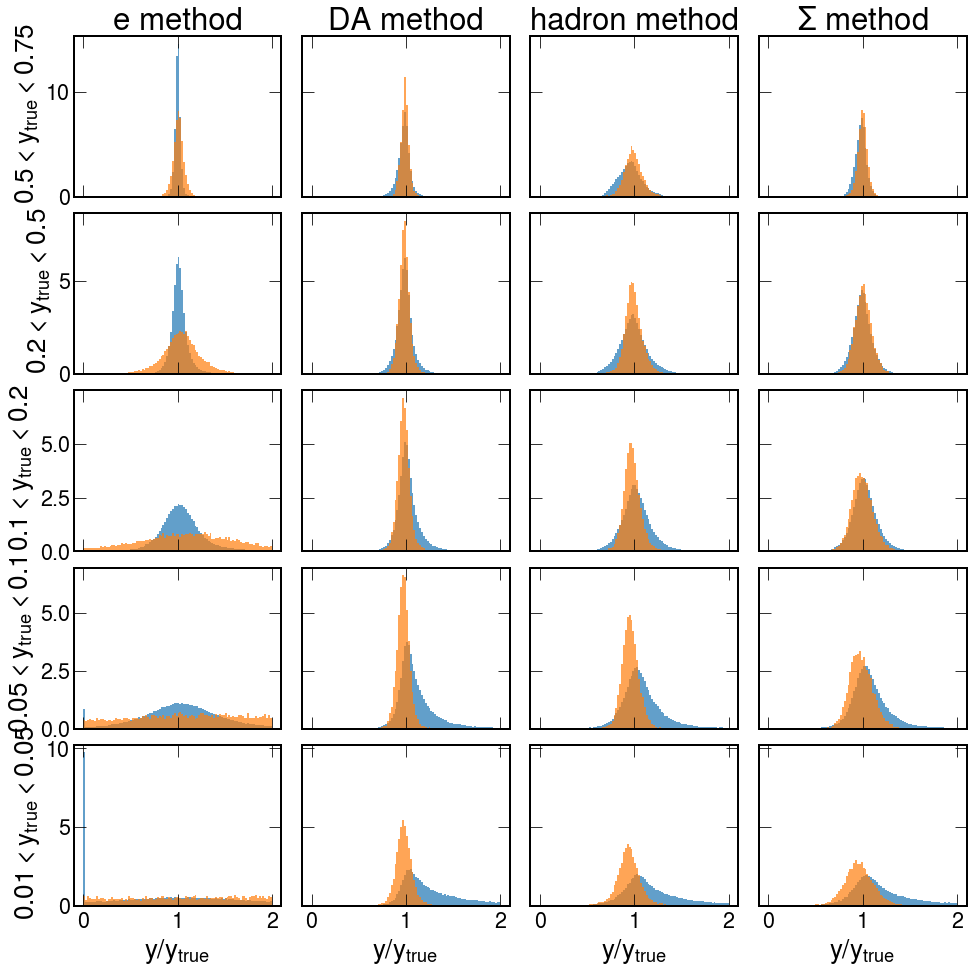

In [18]:
fig,ax = plt.subplots(5,4,figsize=(16,16),sharey='row',sharex=True)
ax = ax.flatten()
ybins = np.array(['gen_y>0.5 and gen_y<0.75', 'gen_y>0.2 and gen_y<0.5',
                  'gen_y>0.1 and gen_y<0.2', 'gen_y>0.05 and gen_y<0.1','gen_y>0.01 and gen_y<0.05'])
print(ybins)



for i in range(5):
    print(ybins[i])
    ax[0 + 4*i].hist(mc.query(ybins[i] + ' and pass_reco>0')['ye_ratio'],density=True,bins=100,range=(0,2),label='e method',alpha=0.7)
    ax[1 + 4*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['yda_ratio'],density=True,bins=100,range=(0,2),label='DA method',alpha=0.7)
    ax[2 + 4*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['yh_ratio'],density=True,bins=100,range=(0,2),label='$\Sigma$ method',alpha=0.7)
    ax[3 + 4*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['ysigma_ratio'],density=True,bins=100,range=(0,2),label='$hadron method',alpha=0.7)

    

for i in range(5):
    print(ybins[i])
    ax[0 + 4*i].hist(owen.query(ybins[i] + ' and pass_reco>0')['ye_ratio'],density=True,bins=100,range=(0,2),label='e method',alpha=0.7)
    ax[1 + 4*i].hist(owen.query(ybins[i]+ ' and pass_reco>0')['yda_ratio'],density=True,bins=100,range=(0,2),label='DA method',alpha=0.7)
    ax[2 + 4*i].hist(owen.query(ybins[i]+ ' and pass_reco>0')['yh_ratio'],density=True,bins=100,range=(0,2),label='$\Sigma$ method',alpha=0.7)
    ax[3 + 4*i].hist(owen.query(ybins[i]+ ' and pass_reco>0')['ysigma_ratio'],density=True,bins=100,range=(0,2),label='$hadron method',alpha=0.7)
    
    
for i in range(len(ax.flatten())):
    #ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
#ax[1].set_title(r"$\bf{ATHENA}$"+' full simulation [DD4hep] \n Pythia8+Geant4, NC DIS 18x275 GeV, $Q^{2}>100$ GeV$^{2}$',fontsize=29)
    ax[i].set_xticks([],minor=True)
    ax[i].set_yticks([], minor=True)
    #ax[i].set_yscale('log')
    # for minor ticks
    #ax[i].set_xticks([], minor=True)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax[0].set_title('e method')
ax[1].set_title('DA method')
ax[3].set_title('$\Sigma$ method')
ax[2].set_title('hadron method')


ax[0].set_ylabel(' $0.5<y_{true}<0.75$')
ax[4].set_ylabel(' $0.2<y_{true}<0.5$')
ax[8].set_ylabel(' $0.1<y_{true}<0.2$')
ax[12].set_ylabel(' $0.05<y_{true}<0.1$')
ax[16].set_ylabel(' $0.01<y_{true}<0.05$')
ax[-1].set_xlabel(r'$y/y_{true}$ ')

ax[-2].set_xlabel(r'$y/y_{true}$ ')
ax[-3].set_xlabel(r'$y/y_{true}$ ')
ax[-4].set_xlabel(r'$y/y_{true}$ ')


plt.show()

['gen_y>0.5 and gen_y<0.7' 'gen_y>0.2 and gen_y<0.5'
 'gen_y>0.1 and gen_y<0.2' 'gen_y>0.05 and gen_y<0.1'
 'gen_y>0.01 and gen_y<0.05']
gen_y>0.5 and gen_y<0.7
gen_y>0.2 and gen_y<0.5
gen_y>0.1 and gen_y<0.2
gen_y>0.05 and gen_y<0.1
gen_y>0.01 and gen_y<0.05


/usr/lib/python3/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/lib/python3/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


gen_y>0.5 and gen_y<0.7
gen_y>0.2 and gen_y<0.5
gen_y>0.1 and gen_y<0.2
gen_y>0.05 and gen_y<0.1
gen_y>0.01 and gen_y<0.05


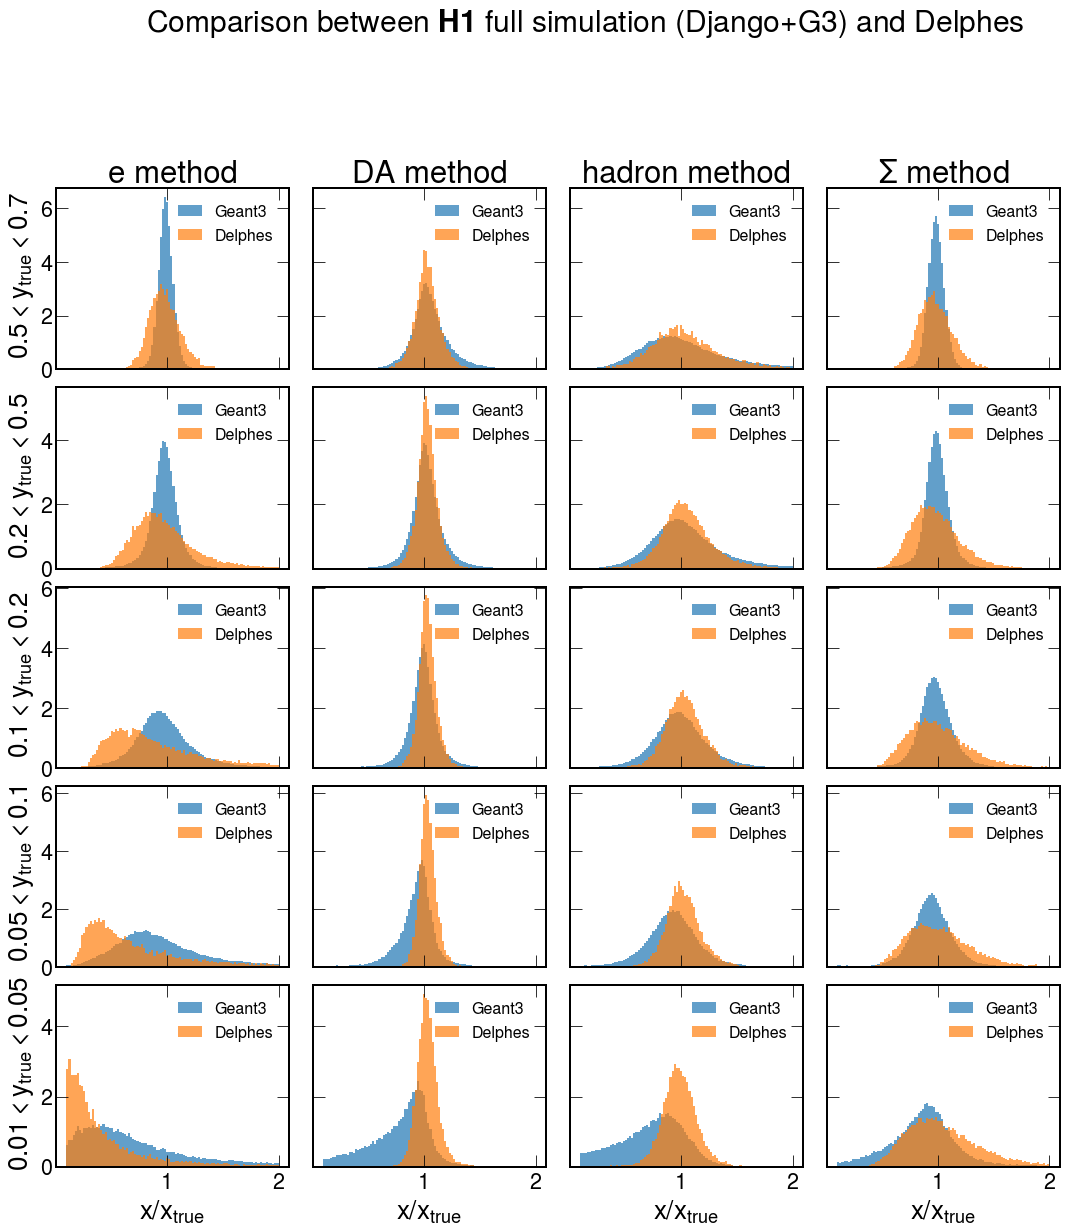

In [19]:
fig,ax = plt.subplots(5,4,figsize=(18,18),sharey='row',sharex=True)
ax = ax.flatten()
ybins = np.array(['gen_y>0.5 and gen_y<0.7', 'gen_y>0.2 and gen_y<0.5',
                  'gen_y>0.1 and gen_y<0.2', 'gen_y>0.05 and gen_y<0.1','gen_y>0.01 and gen_y<0.05'])
print(ybins)


myalpha=0.7
for i in range(5):
    print(ybins[i])
    temp = mc.query(ybins[i] + ' and pass_reco>0')
    ax[0 + 4*i].hist(temp['xe_ratio'],weights=temp['wgt'],density=True,bins=100,range=(0.1,2),alpha=myalpha,label='Geant3')
    ax[1 + 4*i].hist(temp['xda_ratio'],weights=temp['wgt'],density=True,bins=100,range=(0.1,2),alpha=myalpha,label='Geant3')
    ax[2 + 4*i].hist(temp['xh_ratio'],weights=temp['wgt'],density=True,bins=100,range=(0.1,2),alpha=myalpha,label='Geant3')
    ax[3 + 4*i].hist(temp['xsigma_ratio'],weights=temp['wgt'],density=True,bins=100,range=(0.1,2),alpha=myalpha,label='Geant3')

    
    
for i in range(5):
    print(ybins[i])
    ax[0 + 4*i].hist(owen.query(ybins[i] + ' and pass_reco>0')['xe_ratio'],density=True,bins=100,range=(0.1,2),alpha=myalpha,label='Delphes')
    ax[1 + 4*i].hist(owen.query(ybins[i]+ ' and pass_reco>0')['xda_ratio'],density=True,bins=100,range=(0.1,2),alpha=myalpha,label='Delphes')
    ax[2 + 4*i].hist(owen.query(ybins[i]+ ' and pass_reco>0')['xh_ratio'],density=True,bins=100,range=(0.1,2),alpha=myalpha,label='Delphes')
    ax[3 + 4*i].hist(owen.query(ybins[i]+ ' and pass_reco>0')['xsigma_ratio'],density=True,bins=100,range=(0.1,2),alpha=myalpha,label='Delphes')

    
    
#for i in range(5):
#    print(ybins[i])
#    ax[0 + 4*i].hist(owen2.query(ybins[i] + ' and pass_reco>0')['xe_ratio'],density=True,bins=100,range=(0.1,2),alpha=myalpha,label='Delphes')
#    ax[1 + 4*i].hist(owen2.query(ybins[i]+ ' and pass_reco>0')['xda_ratio'],density=True,bins=100,range=(0.1,2),alpha=myalpha,label='Delphes')
#    ax[2 + 4*i].hist(owen2.query(ybins[i]+ ' and pass_reco>0')['xh_ratio'],density=True,bins=100,range=(0.1,2),alpha=myalpha,label='Delphes')
#    ax[3 + 4*i].hist(owen2.query(ybins[i]+ ' and pass_reco>0')['xsigma_ratio'],density=True,bins=100,range=(0.1,2),alpha=myalpha,label='Delphes')
    
for i in range(len(ax.flatten())):
    #ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
#ax[1].set_title(r"$\bf{ATHENA}$"+' full simulation [DD4hep] \n Pythia8+Geant4, NC DIS 18x275 GeV, $Q^{2}>100$ GeV$^{2}$',fontsize=29)
    ax[i].set_xticks([],minor=True)
    ax[i].set_yticks([], minor=True)
    #ax[i].set_yscale('log')
    # for minor ticks
    #ax[i].set_xticks([], minor=True)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax[0].set_title('e method')
ax[1].set_title('DA method')
ax[2].set_title('hadron method')
ax[3].set_title('$\Sigma$ method')


ax[0].set_ylabel(' $0.5<y_{true}<0.7$')
ax[4].set_ylabel(' $0.2<y_{true}<0.5$')
ax[8].set_ylabel(' $0.1<y_{true}<0.2$')
ax[12].set_ylabel(' $0.05<y_{true}<0.1$')
ax[16].set_ylabel(' $0.01<y_{true}<0.05$')
ax[-1].set_xlabel(r'$x/x_{true}$ ')

ax[-2].set_xlabel(r'$x/x_{true}$ ')
ax[-3].set_xlabel(r'$x/x_{true}$ ')
ax[-4].set_xlabel(r'$x/x_{true}$ ')

for i in range(len(ax.flatten())):
    ax[i].legend(loc='best',fontsize=16)    
plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax[0].text(4.75, 12.9,r"Comparison between $\bf{H1}$"+' full simulation (Django+G3) and Delphes ',
                 horizontalalignment='center',multialignment='center',
verticalalignment='center', fontsize=30)
plt.show()

['gen_y>0.5 and gen_y<0.7' 'gen_y>0.2 and gen_y<0.5'
 'gen_y>0.1 and gen_y<0.2' 'gen_y>0.05 and gen_y<0.1'
 'gen_y>0.01 and gen_y<0.05']
gen_y>0.5 and gen_y<0.7
gen_y>0.2 and gen_y<0.5
gen_y>0.1 and gen_y<0.2
gen_y>0.05 and gen_y<0.1
gen_y>0.01 and gen_y<0.05
gen_y>0.5 and gen_y<0.7
gen_y>0.2 and gen_y<0.5
gen_y>0.1 and gen_y<0.2
gen_y>0.05 and gen_y<0.1
gen_y>0.01 and gen_y<0.05


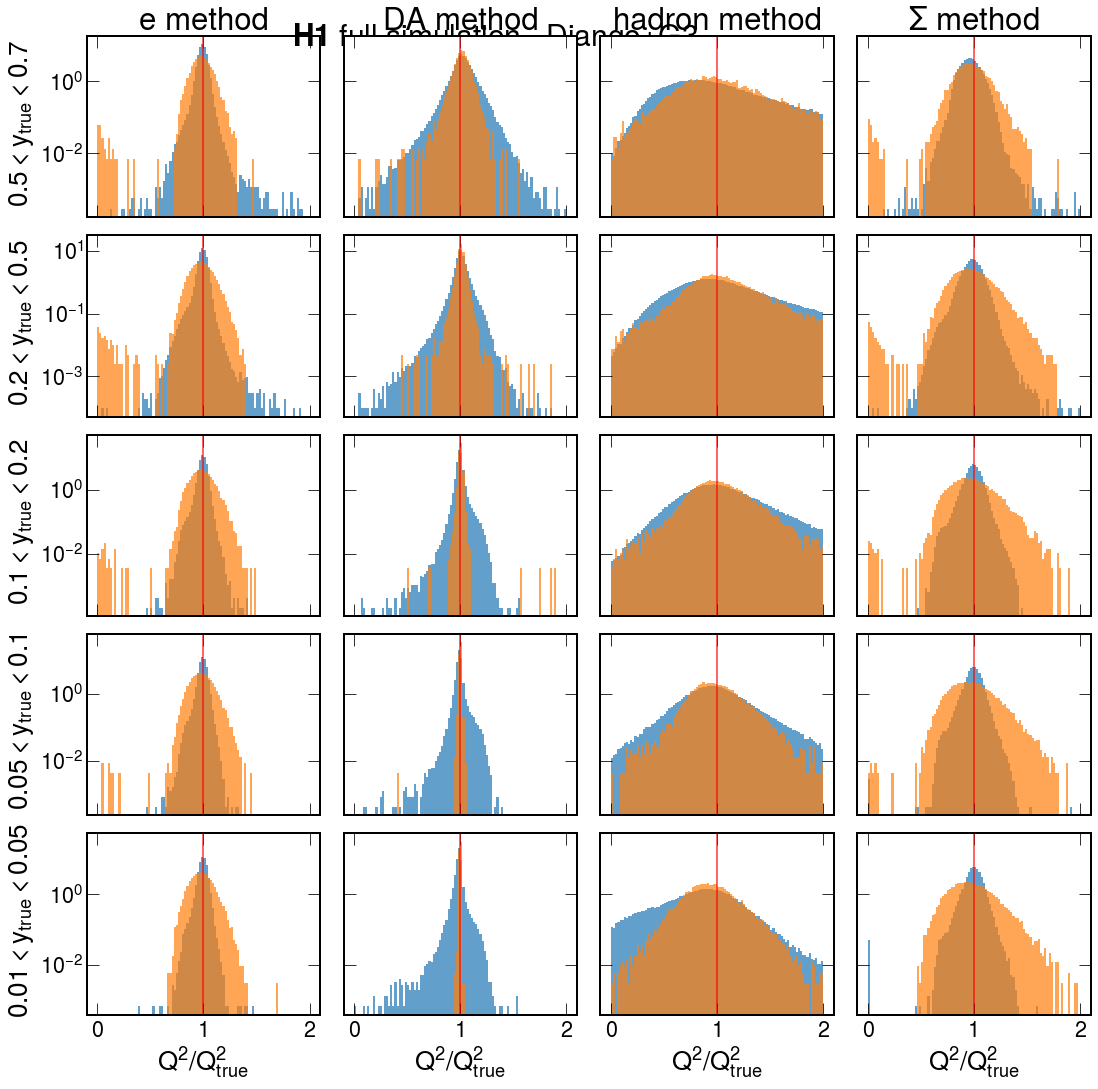

In [20]:
fig,ax = plt.subplots(5,4,figsize=(18,18),sharey='row',sharex=True)
ax = ax.flatten()
ybins = np.array(['gen_y>0.5 and gen_y<0.7', 'gen_y>0.2 and gen_y<0.5',
                  'gen_y>0.1 and gen_y<0.2', 'gen_y>0.05 and gen_y<0.1','gen_y>0.01 and gen_y<0.05'])
print(ybins)



for i in range(5):
    print(ybins[i])
    ax[0 + 4*i].hist(mc.query(ybins[i] + ' and pass_reco>0')['Q2e_ratio'],density=True,bins=100,range=(0,2),label='e method', alpha=0.7)
    ax[1 + 4*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['Q2da_ratio'],density=True,bins=100,range=(0,2),label='DA method', alpha=0.7)
    ax[2 + 4*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['Q2h_ratio'],density=True,bins=100,range=(0,2),label='$\Sigma$ method', alpha=0.7)
    ax[3 + 4*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['Q2sigma_ratio'],density=True,bins=100,range=(0,2),label='$hadron method', alpha=0.7)

for i in range(5):
    print(ybins[i])
    ax[0 + 4*i].hist(owen.query(ybins[i] + ' and pass_reco>0')['Q2e_ratio'],density=True,bins=100,range=(0,2),label='e method', alpha=0.7)
    ax[1 + 4*i].hist(owen.query(ybins[i]+ ' and pass_reco>0')['Q2da_ratio'],density=True,bins=100,range=(0,2),label='DA method', alpha=0.7)
    ax[2 + 4*i].hist(owen.query(ybins[i]+ ' and pass_reco>0')['Q2h_ratio'],density=True,bins=100,range=(0,2),label='$\Sigma$ method', alpha=0.7)
    ax[3 + 4*i].hist(owen.query(ybins[i]+ ' and pass_reco>0')['Q2sigma_ratio'],density=True,bins=100,range=(0,2),label='$hadron method', alpha=0.7)
    
    
    
for i in range(len(ax.flatten())):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
#ax[1].set_title(r"$\bf{ATHENA}$"+' full simulation [DD4hep] \n Pythia8+Geant4, NC DIS 18x275 GeV, $Q^{2}>100$ GeV$^{2}$',fontsize=29)
    ax[i].set_xticks([],minor=True)
    ax[i].set_yticks([], minor=True)
    ax[i].set_yscale('log')
    # for minor ticks
    #ax[i].set_xticks([], minor=True)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax[0].set_title('e method')
ax[1].set_title('DA method')
ax[3].set_title('$\Sigma$ method')
ax[2].set_title('hadron method')


ax[0].set_ylabel(' $0.5<y_{true}<0.7$')
ax[4].set_ylabel(' $0.2<y_{true}<0.5$')
ax[8].set_ylabel(' $0.1<y_{true}<0.2$')
ax[12].set_ylabel(' $0.05<y_{true}<0.1$')
ax[16].set_ylabel(' $0.01<y_{true}<0.05$')
ax[-1].set_xlabel(r'$Q^{2}/Q^{2}_{true}$ ')

ax[-2].set_xlabel(r'$Q^{2}/Q^{2}_{true}$ ')
ax[-3].set_xlabel(r'$Q^{2}/Q^{2}_{true}$ ')
ax[-4].set_xlabel(r'$Q^{2}/Q^{2}_{true}$ ')

ax[0].text(3.75, 16.9,r"$\bf{H1}$"+' full simulation , Django+G3',
                 horizontalalignment='center',multialignment='center',
           verticalalignment='center', fontsize=30)

plt.show()

['gen_y>0.5 and gen_y<0.7' 'gen_y>0.2 and gen_y<0.5'
 'gen_y>0.1 and gen_y<0.2' 'gen_y>0.05 and gen_y<0.1'
 'gen_y>0.01 and gen_y<0.05']
gen_y>0.5 and gen_y<0.7
gen_y>0.2 and gen_y<0.5
gen_y>0.1 and gen_y<0.2
gen_y>0.05 and gen_y<0.1
gen_y>0.01 and gen_y<0.05
gen_y>0.5 and gen_y<0.7
gen_y>0.2 and gen_y<0.5
gen_y>0.1 and gen_y<0.2
gen_y>0.05 and gen_y<0.1
gen_y>0.01 and gen_y<0.05


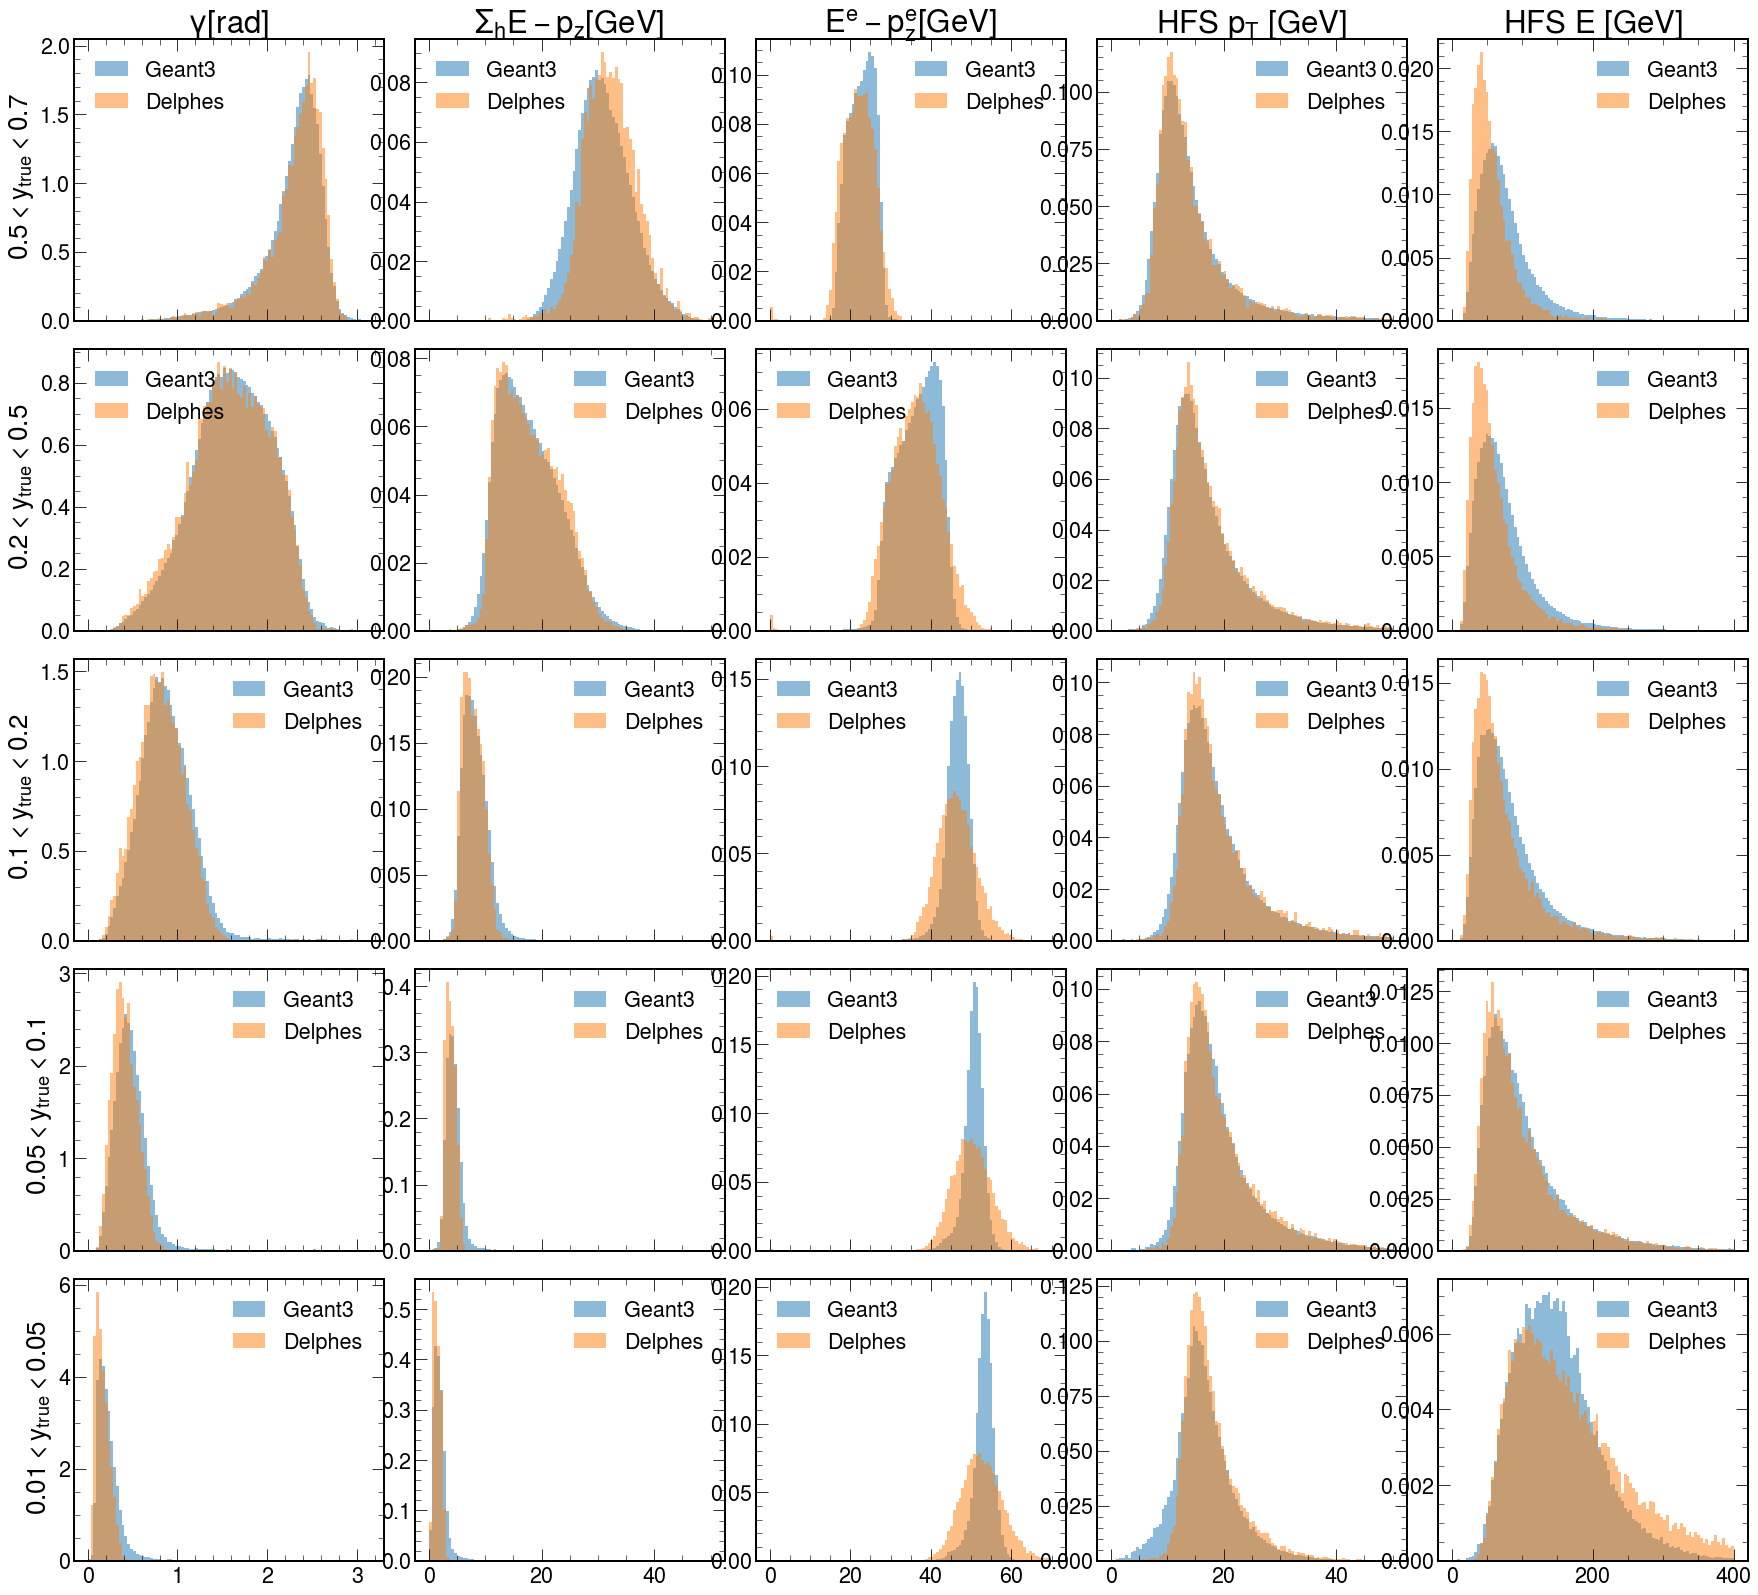

In [21]:
fig,ax = plt.subplots(5,5,figsize=(30,28),sharex='col')#,sharey='col')
ax = ax.flatten()
ybins = np.array(['gen_y>0.5 and gen_y<0.7', 'gen_y>0.2 and gen_y<0.5',
                  'gen_y>0.1 and gen_y<0.2', 'gen_y>0.05 and gen_y<0.1','gen_y>0.01 and gen_y<0.05'])
print(ybins)


myalpha=0.5
for i in range(5):
    print(ybins[i])
    temp = mc.query(ybins[i] + ' and pass_reco>0')
    ax[0 + 5*i].hist(temp['gamma'],weights=temp['wgt'],density=True,bins=100,range=(0,np.pi),alpha=myalpha, label='Geant3')
    ax[1 + 5*i].hist(temp['Sigma'],weights=temp['wgt'],density=True,bins=100,range=(0,50),alpha=myalpha,label='Geant3')
    
    #ax[2 + 5*i].hist(temp['my_EMPZ'],weights=temp['wgt'],density=True,bins=100,range=(40,70),alpha=myalpha, label='Geant3')

    ax[2 + 5*i].hist(temp['e_empz'],weights=temp['wgt'],density=True,bins=100,range=(0,70),alpha=myalpha, label='Geant3')
    ax[3 + 5*i].hist(temp['HFS_pt'],weights=temp['wgt'],density=True,bins=100,range=(0,50),alpha=myalpha,label='Geant3')
    #ax[4 + 5*i].hist(temp['HFS_eta'],weights=temp['wgt'],density=True,bins=100,range=(-2,4.0),alpha=myalpha,label='Geant3')
    ax[4 + 5*i].hist(temp['HFS_E'],weights=temp['wgt'],density=True,bins=100,range=(0,400),alpha=myalpha,label='Geant3')

    
for i in range(5):
    print(ybins[i])
    temp = owen.query(ybins[i] + ' and pass_reco>0')
    ax[0 + 5*i].hist(temp['gamma'],density=True,bins=100,range=(0,np.pi),alpha=myalpha, label='Delphes')
    ax[1 + 5*i].hist(temp['Sigma'],density=True,bins=100,range=(0,50),alpha=myalpha, label='Delphes')
    #ax[2 + 5*i].hist(temp['my_EMPZ'],density=True,bins=100,range=(40,70),alpha=myalpha, label='Delphes')

    ax[2 + 5*i].hist(temp['e_empz'],density=True,bins=100,range=(0,70),alpha=myalpha, label='Delphes')
    ax[3 + 5*i].hist(temp['HFS_pt'],density=True,bins=100,range=(0,50),alpha=myalpha, label='Delphes')
    #ax[4 + 5*i].hist(temp['HFS_eta'],density=True,bins=100,range=(-2,4.0),alpha=myalpha, label='Delphes')
    ax[4 + 5*i].hist(temp['HFS_E'],density=True,bins=100,range=(0,400),alpha=myalpha, label='Delphes')

    
    
#for i in range(5):
#    print(ybins[i])
#    temp = owen2.query(ybins[i] + ' and pass_reco>0')
#    ax[0 + 5*i].hist(temp['gamma'],density=True,bins=100,range=(0,np.pi),alpha=0.7, label='Delphes')
#    ax[1 + 5*i].hist(temp['Sigma'],density=True,bins=100,range=(0,50),alpha=0.7, label='Delphes')
#    ax[2 + 5*i].hist(temp['e_empz'],density=True,bins=100,range=(0,70),alpha=0.7, label='Delphes')
#    ax[3 + 5*i].hist(temp['HFS_pt'],density=True,bins=100,range=(0,50),alpha=0.7, label='Delphes')
#    ax[4 + 5*i].hist(temp['HFS_eta'],density=True,bins=100,range=(-2,4.0),alpha=0.7, label='Delphes')
    
    
for i in range(len(ax.flatten())):
    ax[i].legend(loc='best')    
plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax[0].set_title('$\gamma [rad]$ ')
ax[1].set_title('$\Sigma_{h} E-p_{z} [GeV]$')
ax[2].set_title('$E^{e}-p^{e}_{z} [GeV]$')
ax[3].set_title('HFS $p_{T}$ [GeV]')
ax[4].set_title('HFS $E$ [GeV]')

#ax[2].set_title('hadron method')
#ax[3].set_title('$\Sigma$ method')


ax[0].set_ylabel(' $0.5<y_{true}<0.7$')
ax[5].set_ylabel(' $0.2<y_{true}<0.5$')
ax[10].set_ylabel(' $0.1<y_{true}<0.2$')
ax[15].set_ylabel(' $0.05<y_{true}<0.1$')
ax[20].set_ylabel(' $0.01<y_{true}<0.05$')
#ax[-1].set_xlabel(r'$x/x_{true}$ ')

#ax[-2].set_xlabel(r'$x/x_{true}$ ')
#ax[-3].set_xlabel(r'$x/x_{true}$ ')
#ax[-4].set_xlabel(r'$x/x_{true}$ ')
plt.show()


['gen_y>0.5 and gen_y<0.7' 'gen_y>0.2 and gen_y<0.5'
 'gen_y>0.1 and gen_y<0.2' 'gen_y>0.05 and gen_y<0.1'
 'gen_y>0.01 and gen_y<0.05']
gen_y>0.5 and gen_y<0.7
gen_y>0.2 and gen_y<0.5
gen_y>0.1 and gen_y<0.2
gen_y>0.05 and gen_y<0.1
gen_y>0.01 and gen_y<0.05
gen_y>0.5 and gen_y<0.7
gen_y>0.2 and gen_y<0.5
gen_y>0.1 and gen_y<0.2
gen_y>0.05 and gen_y<0.1
gen_y>0.01 and gen_y<0.05


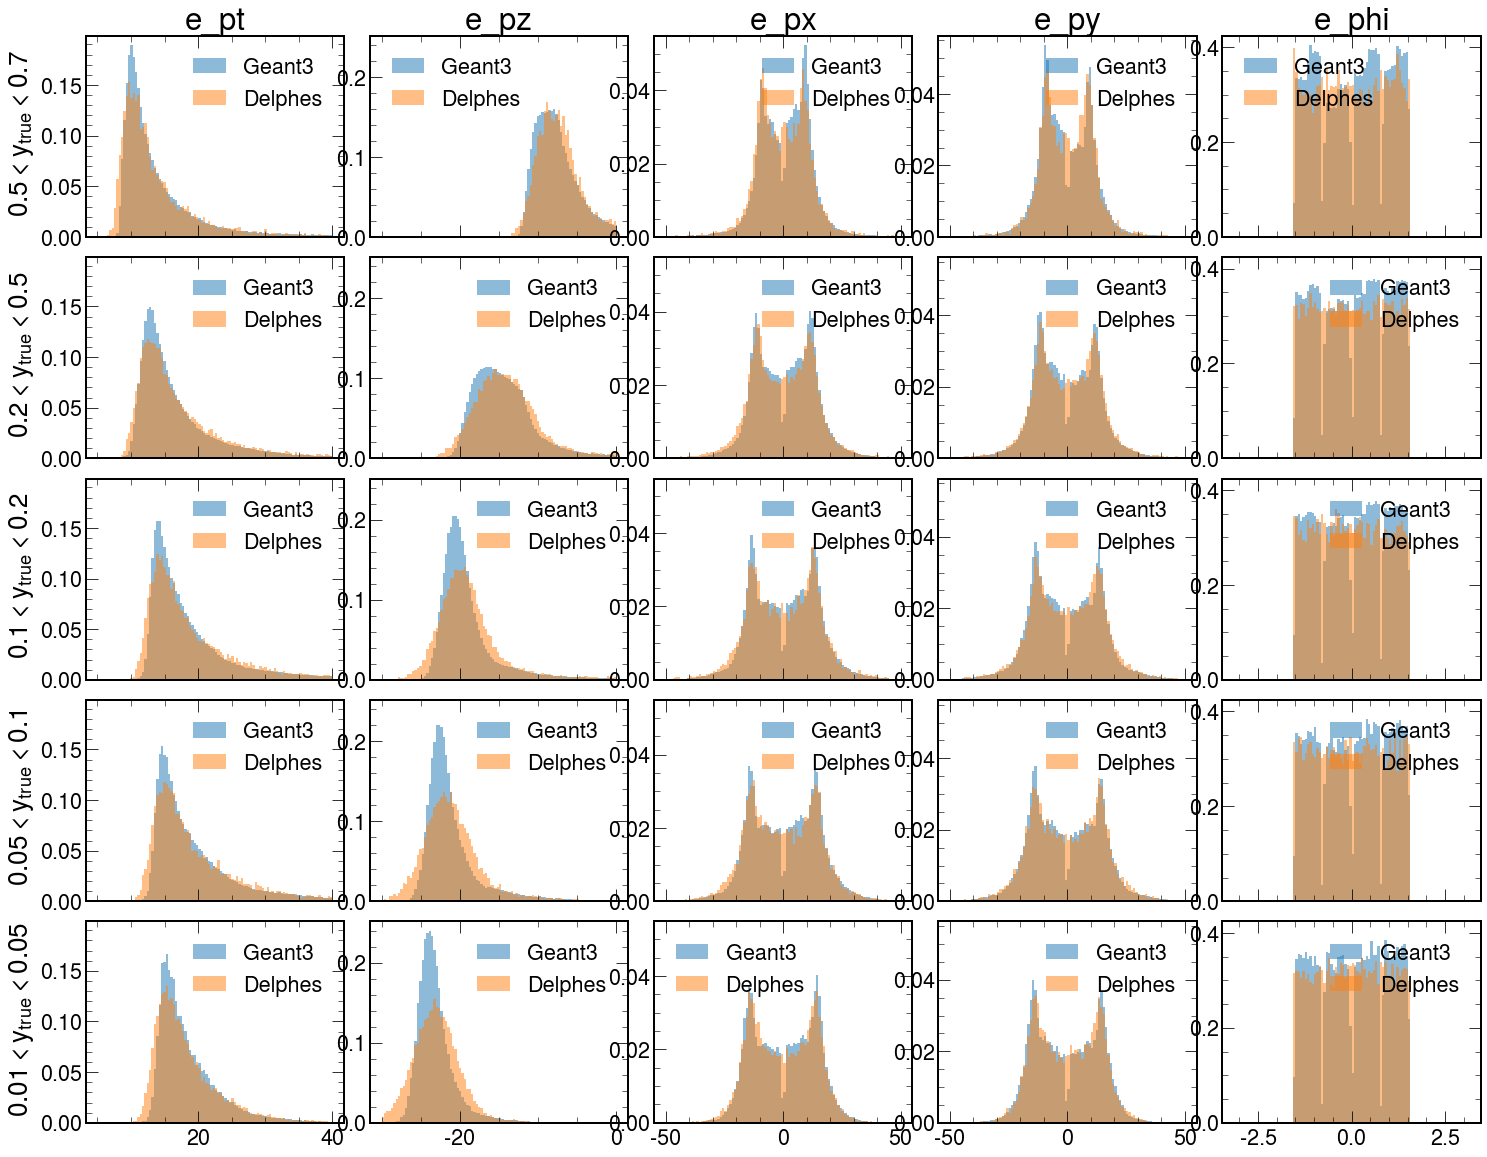

In [22]:
fig,ax = plt.subplots(5,5,figsize=(25,20),sharex='col',sharey='col')
ax = ax.flatten()
ybins = np.array(['gen_y>0.5 and gen_y<0.7', 'gen_y>0.2 and gen_y<0.5',
                  'gen_y>0.1 and gen_y<0.2', 'gen_y>0.05 and gen_y<0.1','gen_y>0.01 and gen_y<0.05'])
print(ybins)


myalpha=0.5
for i in range(5):
    print(ybins[i])
    temp = mc.query(ybins[i] + ' and pass_reco>0')
    ax[0 + 5*i].hist(temp['e_pt'],weights=temp['wgt'],density=True,bins=100,range=(5,40),alpha=myalpha, label='Geant3')
    ax[1 + 5*i].hist(temp['e_pz'],weights=temp['wgt'],density=True,bins=100,range=(-30,0),alpha=myalpha, label='Geant3')
    #ax[1 + 5*i].hist(temp['gene_pz'],weights=temp['wgt'],density=True,bins=100,range=(-50,50),alpha=0.7, label='Geant3')

    ax[2 + 5*i].hist(temp['e_px'],weights=temp['wgt'],density=True,bins=100,range=(-50,50),alpha=myalpha,label='Geant3')
    ax[3 + 5*i].hist(temp['e_py'],weights=temp['wgt'],density=True,bins=100,range=(-50,50),alpha=myalpha,label='Geant3')
    ax[4 + 5*i].hist(temp['e_phi'],weights=temp['wgt'],density=True,bins=100,range=(-np.pi,np.pi),alpha=myalpha,label='Geant3')


for i in range(5):
    print(ybins[i])
    temp = owen.query(ybins[i] + ' and pass_reco>0')
    ax[0 + 5*i].hist(temp['e_pt'],density=True,bins=100,range=(5,40),alpha=myalpha, label='Delphes')
    ax[1 + 5*i].hist(temp['e_pz'],density=True,bins=100,range=(-30,0),alpha=myalpha, label='Delphes')
    #ax[1 + 5*i].hist(temp['gene_pz'],density=True,bins=100,range=(-50,50),alpha=0.7, label='Delphes truth')

    ax[2 + 5*i].hist(temp['e_px'],density=True,bins=100,range=(-50,50),alpha=myalpha,label='Delphes')
    ax[3 + 5*i].hist(temp['e_py'],density=True,bins=100,range=(-50,50),alpha=myalpha,label='Delphes')
   # ax[3 + 5*i].hist(temp['e_eta'],density=True,bins=100,range=(-3,2),alpha=0.7,label='Geant3')

    ax[4 + 5*i].hist(temp['e_phi'],density=True,bins=100,range=(-np.pi,np.pi),alpha=myalpha,label='Delphes')
    
#for i in range(5):
#    print(ybins[i])
#    temp = owen.query(ybins[i] + ' and pass_reco>0')
#    ax[0 + 5*i].hist(temp['e_pt'],density=True,bins=100,range=(5,40),alpha=0.7, label='Delphes')
#    ax[1 + 5*i].hist(temp['gamma'],density=True,bins=100,range=(0,np.pi),alpha=0.7, label='Delphes')
#    ax[2 + 5*i].hist(temp['Sigma'],density=True,bins=100,range=(0,50),alpha=0.7, label='Delphes')
#    ax[3 + 5*i].hist(temp['HFS_pt'],density=True,bins=100,range=(0,50),alpha=0.7, label='Delphes')
#    ax[4 + 5*i].hist(temp['HFS_eta'],density=True,bins=100,range=(-2,4.0),alpha=0.7, label='Delphes')

for i in range(len(ax.flatten())):
    ax[i].legend(loc='best')    
plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax[0].set_title('e_pt')
ax[1].set_title('e_pz')
ax[2].set_title('e_px')
ax[3].set_title('e_py')
ax[4].set_title('e_phi')

#ax[2].set_title('hadron method')
#ax[3].set_title('$\Sigma$ method')


ax[0].set_ylabel(' $0.5<y_{true}<0.7$')
ax[5].set_ylabel(' $0.2<y_{true}<0.5$')
ax[10].set_ylabel(' $0.1<y_{true}<0.2$')
ax[15].set_ylabel(' $0.05<y_{true}<0.1$')
ax[20].set_ylabel(' $0.01<y_{true}<0.05$')
#ax[-1].set_xlabel(r'$x/x_{true}$ ')

#ax[-2].set_xlabel(r'$x/x_{true}$ ')
#ax[-3].set_xlabel(r'$x/x_{true}$ ')
#ax[-4].set_xlabel(r'$x/x_{true}$ ')

#ax[2].text(0.75, 0.5,r"Comparigon of $\bf{H1}$"+' full simulation (Django+G3) and fast-sim (Delphes)',
#                 horizontalalignment='center',multialignment='center',
#           verticalalignment='center', fontsize=30)

plt.show()


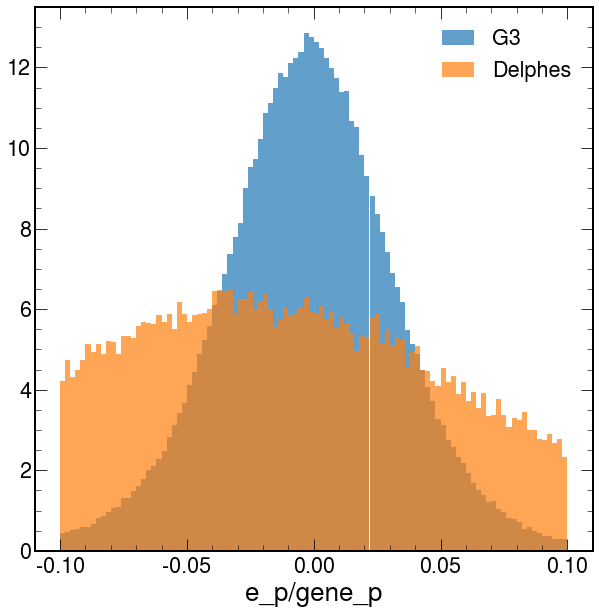

In [23]:
plt.hist(mc.query('pass_reco>0 ')['p_res'],weights=mc.query('pass_reco>0')['wgt'],range=(-0.1,0.1),bins=100,density=True,alpha=0.7,label='G3')
plt.hist(owen.query('pass_reco>0')['p_res'],bins=100,range=(-0.1,0.1),density=True,alpha=0.7,label='Delphes')
#plt.hist(owen2.query('pass_reco>0')['p_res'],bins=100,range=(-0.1,0.1),density=True,alpha=0.7,label='Delphes')

plt.legend()
plt.xlabel('e_p/gene_p')
plt.show()

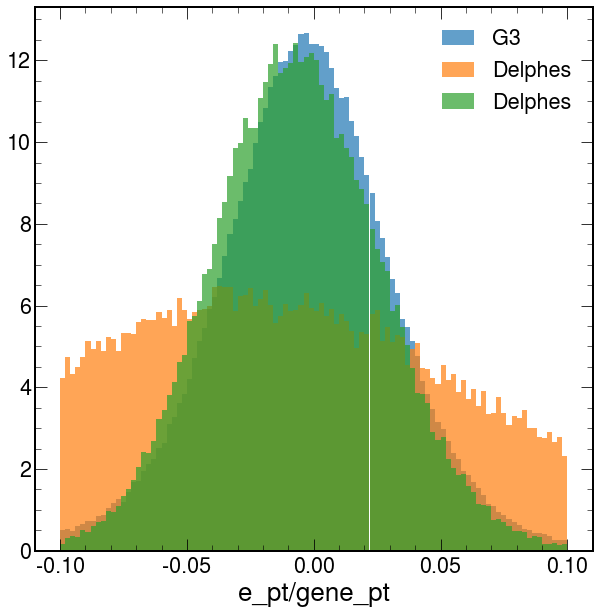

In [24]:
plt.hist(mc.query('pass_reco>0 ')['pt_res'],weights=mc.query('pass_reco>0')['wgt'],range=(-0.1,0.1),bins=100,density=True,alpha=0.7,label='G3')
plt.hist(owen.query('pass_reco>0')['pt_res'],bins=100,range=(-0.1,0.1),density=True,alpha=0.7,label='Delphes')
plt.hist(owen2.query('pass_reco>0')['pt_res'],bins=100,range=(-0.1,0.1),density=True,alpha=0.7,label='Delphes')

plt.legend()
plt.xlabel('e_pt/gene_pt')
plt.show()

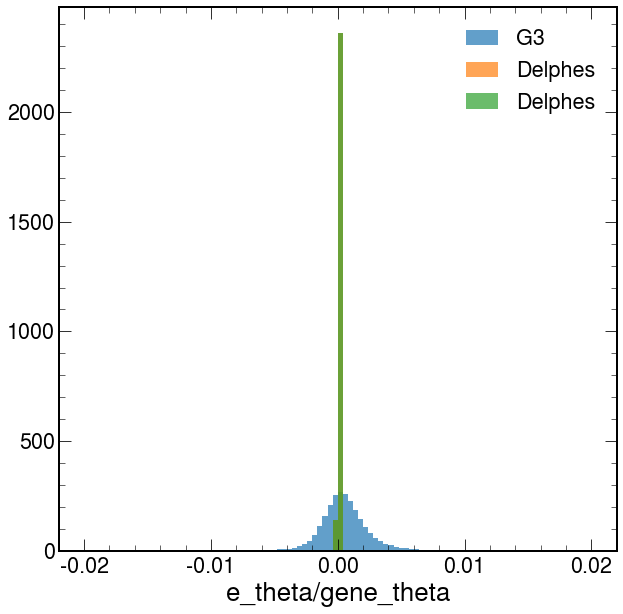

In [25]:
plt.hist(mc.query('pass_reco>0 ')['theta_res'],weights=mc.query('pass_reco>0')['wgt'],range=(-0.02,0.02),bins=100,density=True,alpha=0.7,label='G3')
plt.hist(owen.query('pass_reco>0')['theta_res'],bins=100,range=(-0.02,0.02),density=True,alpha=0.7,label='Delphes')
plt.hist(owen2.query('pass_reco>0')['theta_res'],bins=100,range=(-0.02,0.02),density=True,alpha=0.7,label='Delphes')

plt.legend()
plt.xlabel('e_theta/gene_theta')
plt.show()

[11.2675, 14.123000000000001, 17.702, 22.189, 27.813, 34.862, 43.698, 54.7735, 68.656, 86.057, 107.868]
[11.2675, 14.123000000000001, 17.702, 22.189, 27.813, 34.862, 43.698, 54.7735, 68.656, 86.057, 107.868]
[11.2675, 14.123000000000001, 17.702, 22.189, 27.813, 34.862, 43.698, 54.7735, 68.656, 86.057, 107.868]


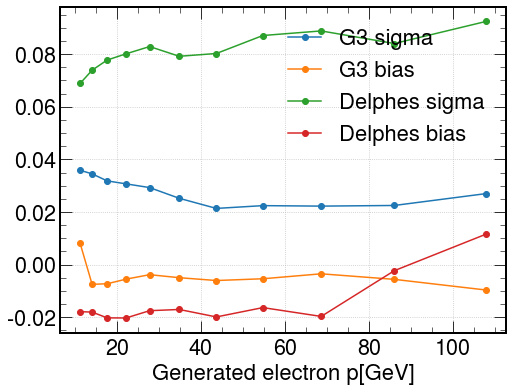

<Figure size 720x720 with 0 Axes>

In [26]:
from scipy import stats

fig = plt.figure( figsize=(8, 6))
temp = mc.query('pass_reco>0').groupby(pd.cut(mc.query('pass_reco>0')['gene_p'], bins=np.geomspace(10,120,12)))['p_res']
trim_mean = temp.apply(stats.trim_mean, 0.025)
trim_std = temp.apply(stats.mstats.trimmed_std, limits=(0.025,0.025))
temp = temp.agg(['mean', 'std', 'size']).reset_index()


x = [i.mid for i in temp['gene_p']]
print (x)

plt.plot(x, trim_std,'o-',label='G3 sigma')
#plt.plot(x, temp['std'],'o-',label='JER (trimmed)')
plt.plot(x, temp['mean'],'o-',label='G3 bias')



####
temp = owen.query('pass_reco>0').groupby(pd.cut(owen.query('pass_reco>0')['gene_p'], bins=np.geomspace(10,120,12)))['p_res']
trim_mean = temp.apply(stats.trim_mean, 0.025)
trim_std = temp.apply(stats.mstats.trimmed_std, limits=(0.025,0.025))
temp = temp.agg(['mean', 'std', 'size']).reset_index()


x = [i.mid for i in temp['gene_p']]
print (x)

plt.plot(x, trim_std,'o-',label='Delphes sigma')
#plt.plot(x, temp['std'],'o-',label='JER (trimmed)')
plt.plot(x, temp['mean'],'o-',label='Delphes bias')

####
temp = owen2.query('pass_reco>0').groupby(pd.cut(owen2.query('pass_reco>0')['gene_p'], bins=np.geomspace(10,120,12)))['p_res']
trim_mean = temp.apply(stats.trim_mean, 0.025)
trim_std = temp.apply(stats.mstats.trimmed_std, limits=(0.025,0.025))
temp = temp.agg(['mean', 'std', 'size']).reset_index()


x = [i.mid for i in temp['gene_p']]
print (x)

#plt.plot(x, trim_std,'o-',label='Delphes 2 sigma')
#plt.plot(x, temp['std'],'o-',label='JER (trimmed)')
#plt.plot(x, temp['mean'],'o-',label='Delphes 2 bias')


plt.xlabel('Generated electron p[GeV]',fontsize=22)
plt.legend(fontsize=22)
plt.grid()
#plt.ylim([-0.4,0.5])
plt.show()
plt.tight_layout()

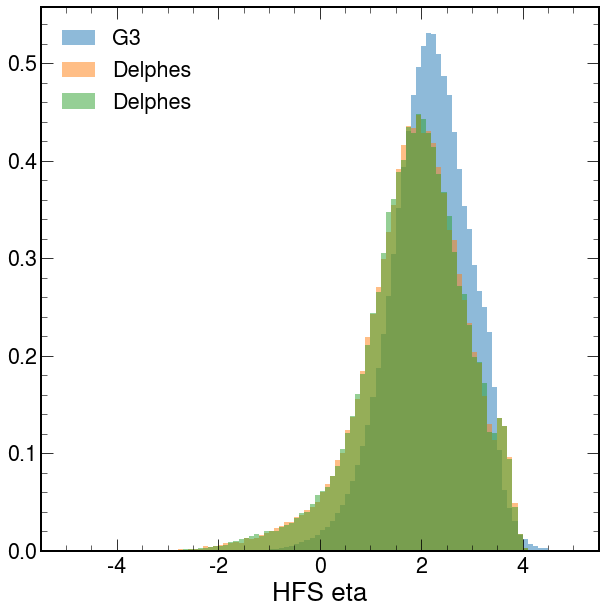

In [27]:
plt.hist(mc.query('pass_reco>0')['HFS_eta'],weights=mc.query('pass_reco>0')['wgt'],density=True,range=(-5,5),bins=100,alpha=0.5,label='G3')
plt.hist(owen.query('pass_reco>0')['HFS_eta'],density=True,range=(-5,5),bins=100,alpha=0.5,label='Delphes')
plt.hist(owen2.query('pass_reco>0')['HFS_eta'],density=True,range=(-5,5),bins=100,alpha=0.5,label='Delphes')

#plt.hist(owen.query('pass_reco>0')['gen_HFS_eta'],density=True,range=(-5,5),histtype='step',bins=100,alpha=0.5,label='Delphes')
#plt.hist(owen2.query('pass_reco>0')['gen_HFS_eta'],density=True,range=(-5,5),histtype='step',bins=100,alpha=0.5,label='Delphes')
plt.legend()
plt.xlabel('HFS eta')
plt.show()

In [28]:
owen.keys()

Index(['Q2_e', 'Q2_sigma', 'Q2_esigma', 'Q2_da', 'Q2_h', 'gen_Q2', 'y_e',
       'y_sigma', 'y_esigma', 'y_da', 'y_h', 'HFS_px', 'HFS_py', 'HFS_pz',
       'HFS_E', 'HFS_pt', 'HFS_eta', 'HFS_phi', 'HFS_theta', 'HFS_gamma',
       'gen_y', 'e_px', 'e_py', 'e_pz', 'gene_px', 'gene_py', 'gene_pz',
       'Empz', 'pth', 'gen_s', 'gen_HFS_px', 'gen_HFS_py', 'gen_HFS_pz',
       'gen_HFS_e', 'gen_HFS_pt', 'gen_HFS_eta', 'gen_HFS_phi',
       'gen_HFS_theta', 'genHFS_px', 'genHFS_py', 'genHFS_pz', 'pass_reco',
       'pass_truth', 'e_pt', 'e_p', 'e_empz', 'e_theta', 'e_phi', 's', 'x_e',
       'x_da', 'x_sigma', 'x_esigma', 'x_h', 'Sigma', 'my_EMPZ', 'gamma',
       'gen_x', 'gen_logQ2', 'gene_pt', 'gene_p', 'gene_theta', 'genHFS_pt',
       'yda_ratio', 'ysigma_ratio', 'yesigma_ratio', 'ye_ratio', 'yh_ratio',
       'Q2e_ratio', 'Q2da_ratio', 'Q2sigma_ratio', 'Q2esigma_ratio',
       'Q2h_ratio', 'xe_ratio', 'xda_ratio', 'xsigma_ratio', 'xesigma_ratio',
       'xh_ratio', 'p_res', 'pt_res', 

[11.2675, 14.123000000000001, 17.702, 22.189, 27.813, 34.862, 43.698, 54.7735, 68.656, 86.057, 107.868]
[11.2675, 14.123000000000001, 17.702, 22.189, 27.813, 34.862, 43.698, 54.7735, 68.656, 86.057, 107.868]
[11.2675, 14.123000000000001, 17.702, 22.189, 27.813, 34.862, 43.698, 54.7735, 68.656, 86.057, 107.868]


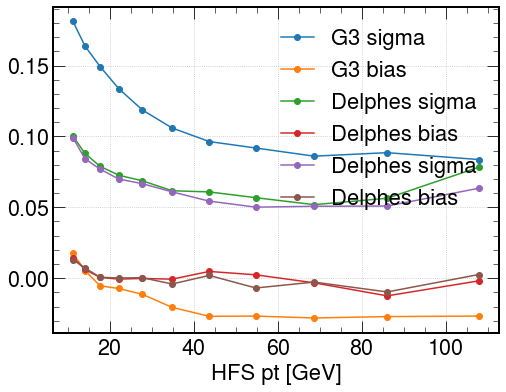

<Figure size 720x720 with 0 Axes>

In [29]:
fig = plt.figure( figsize=(8, 6))
temp = mc.query('pass_reco>0').groupby(pd.cut(mc.query('pass_reco>0')['genHFS_pt'], bins=np.geomspace(10,120,12)))['HFSpt_res']
trim_mean = temp.apply(stats.trim_mean, 0.025)
trim_std = temp.apply(stats.mstats.trimmed_std, limits=(0.025,0.025))
temp = temp.agg(['mean', 'std', 'size']).reset_index()


x = [i.mid for i in temp['genHFS_pt']]
print (x)

plt.plot(x, trim_std,'o-',label='G3 sigma')
#plt.plot(x, temp['std'],'o-',label='JER (trimmed)')
plt.plot(x, temp['mean'],'o-',label='G3 bias')



####
temp = owen.query('pass_reco>0').groupby(pd.cut(owen.query('pass_reco>0')['genHFS_pt'], bins=np.geomspace(10,120,12)))['HFSpt_res']
trim_mean = temp.apply(stats.trim_mean, 0.025)
trim_std = temp.apply(stats.mstats.trimmed_std, limits=(0.025,0.025))
temp = temp.agg(['mean', 'std', 'size']).reset_index()


x = [i.mid for i in temp['genHFS_pt']]
print (x)

plt.plot(x, trim_std,'o-',label='Delphes sigma')
#plt.plot(x, temp['std'],'o-',label='JER (trimmed)')
plt.plot(x, temp['mean'],'o-',label='Delphes bias')



####
temp = owen2.query('pass_reco>0').groupby(pd.cut(owen2.query('pass_reco>0')['genHFS_pt'], bins=np.geomspace(10,120,12)))['HFSpt_res']
trim_mean = temp.apply(stats.trim_mean, 0.025)
trim_std = temp.apply(stats.mstats.trimmed_std, limits=(0.025,0.025))
temp = temp.agg(['mean', 'std', 'size']).reset_index()


x = [i.mid for i in temp['genHFS_pt']]
print (x)

plt.plot(x, trim_std,'o-',label='Delphes sigma')
#plt.plot(x, temp['std'],'o-',label='JER (trimmed)')
plt.plot(x, temp['mean'],'o-',label='Delphes bias')



plt.xlabel('HFS pt [GeV]',fontsize=22)
plt.legend(fontsize=22)
plt.grid()
#plt.ylim([-0.4,0.5])
plt.show()
plt.tight_layout()

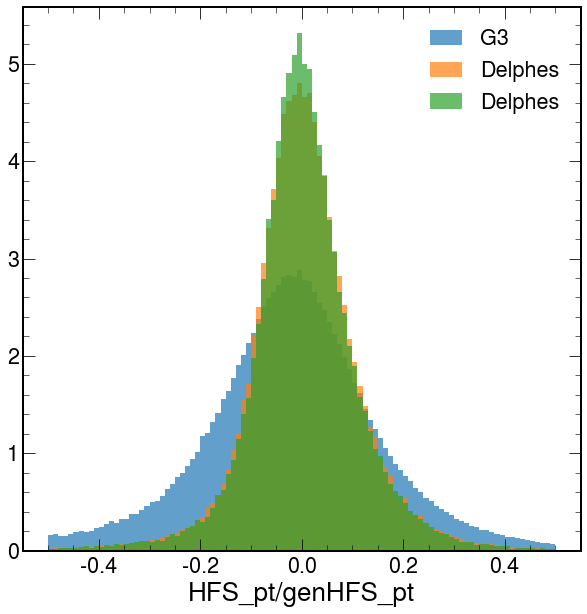

In [30]:
plt.hist(mc.query('pass_reco>0 ')['HFSpt_res'],weights=mc.query('pass_reco>0')['wgt'],range=(-0.5,0.5),bins=100,density=True,alpha=0.7,label='G3')
plt.hist(owen.query('pass_reco>0')['HFSpt_res'],bins=100,range=(-0.5,0.5),density=True,alpha=0.7,label='Delphes')
plt.hist(owen2.query('pass_reco>0')['HFSpt_res'],bins=100,range=(-0.5,0.5),density=True,alpha=0.7,label='Delphes')

plt.legend()
plt.xlabel('HFS_pt/genHFS_pt')
plt.show()

In [31]:
x = np.linspace(0.1,25,100)

In [32]:
def Calo_res(x, s = 50, c=3):
    return np.sqrt(np.divide(s**2,x) + c*c)

def tracker_res(x, s=0.4, c=1.5):
    return np.sqrt(np.multiply(s**2,x**2) + c*c)

In [33]:
Calo_res(x)

array([158.14234095,  84.38642643,  64.45718457,  54.17132004,
        47.63689718,  43.01764588,  39.53065034,  36.77836604,
        34.53468097,  32.66025578,  31.06392691,  29.68321113,
        28.47365925,  27.40267277,  26.44572875,  25.58397753,
        24.80265978,  24.09003196,  23.4366177 ,  22.83467452,
        22.27780621,  21.76067616,  21.27879184,  20.82834063,
        20.40606301,  20.0091535 ,  19.63518252,  19.28203396,
        18.94785511,  18.63101592,  18.33007574,  18.04375598,
        17.77091736,  17.51054104,  17.26171269,  17.02360912,
        16.79548693,  16.57667284,  16.3665554 ,  16.16457788,
        15.97023215,  15.78305335,  15.60261525,  15.42852626,
        15.26042585,  15.09798147,  14.94088585,  14.78885454,
        14.64162379,  14.49894866,  14.36060133,  14.2263696 ,
        14.09605552,  13.9694742 ,  13.8464527 ,  13.72682911,
        13.61045158,  13.49717761,  13.38687328,  13.27941261,
        13.17467694,  13.07255445,  12.97293959,  12.87

(0.0, 20)

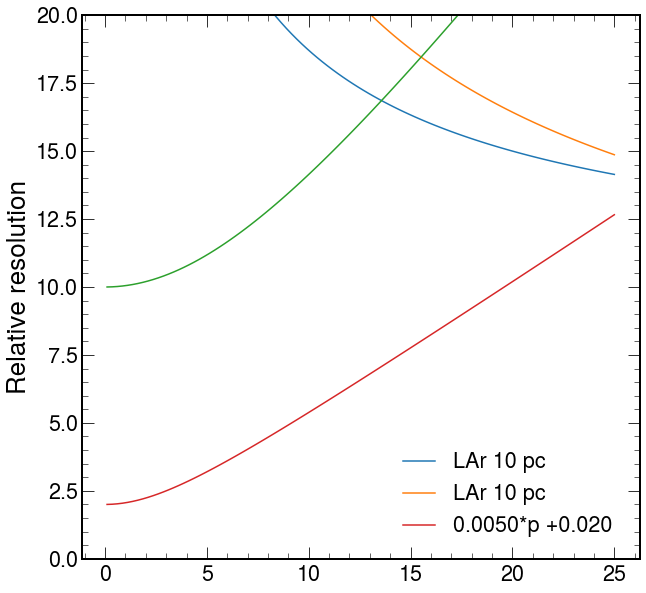

In [34]:
#plt.plot(x,Calo_res(x,s=50,c=3),label='LAr')
plt.plot(x,Calo_res(x,s=50,c=10),label='LAr 10 pc')
plt.plot(x,Calo_res(x,s=70,c=5),label='LAr 10 pc')

plt.plot(x,tracker_res(x,s=1.0,c=10.0))

plt.plot(x,tracker_res(x,s=0.50,c=2.0), label='0.0050*p +0.020 ')
#plt.plot(x,tracker_res(x,s=0.3,c=2.0), label='0.0030*p +0.020 ')
#plt.plot(x,tracker_res(x,s=0.2,c=1.5), label='0.002*p +0.015 ')
plt.ylabel('Relative resolution')
plt.legend()
plt.ylim([0.0,20])